# Generative Adversarial Network (GAN)

Generative Adversarial Networks (GANs) help machines create new and realistic data by learning from existing examples. Introduced by Ian Goodfellow and his team in 2014, they have transformed how computers generate images, videos, music, and more. Unlike traditional models that only recognize or classify data, GANs take a creative approach by generating entirely new content that closely resembles real-world data. This capability has benefited diverse fields such as art, video games, healthcare, and data science. In this article, we'll explore GANs and their core concepts in more detail.

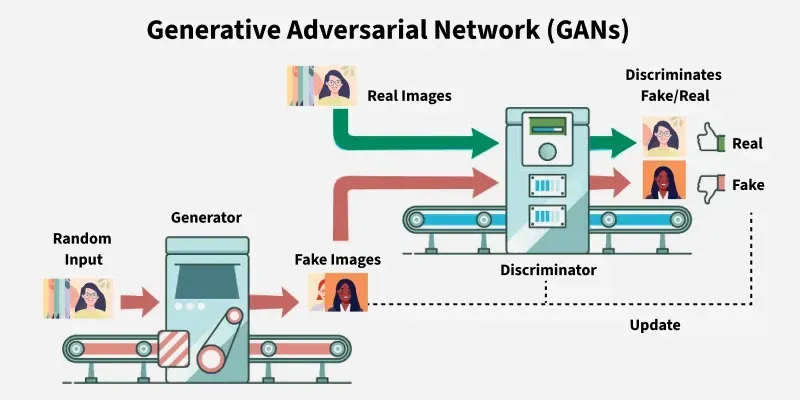

# GAN Architecture

A GAN consists of two main models that work together to create realistic synthetic images.

---

## 1. Generator Model

The generator is a deep neural network that takes random noise as input to generate realistic images.

### Generator Loss Function
$$L_G = \text{BCE}(1, D(G(z)))$$

**Where:**
* $L_G$ measures how well the generator fools the discriminator.
* $G(z)$ is the generated sample from the random vector $z$.
* $D(G(z))$ is the probability that the generated sample is real.

---

## 2. Discriminator Model

The discriminator acts as a binary classifier designed to distinguish between real data and generated data.

### Discriminator Loss Function
$$L_D = \text{BCE}(1, D(x)) + \text{BCE}(0, D(G(z)))$$

**Where:**
* $L_D$ measures how well the discriminator classifies real and fake images.
* $x$ represents the real images.
* $G(z)$ is the generated sample from the random vector $z$.
* $D(x)$ is the probability that $x$ is real.
* $D(G(z))$ is the probability that the generated sample is real.

Our goal is to generate anime-style face images like the ones below.

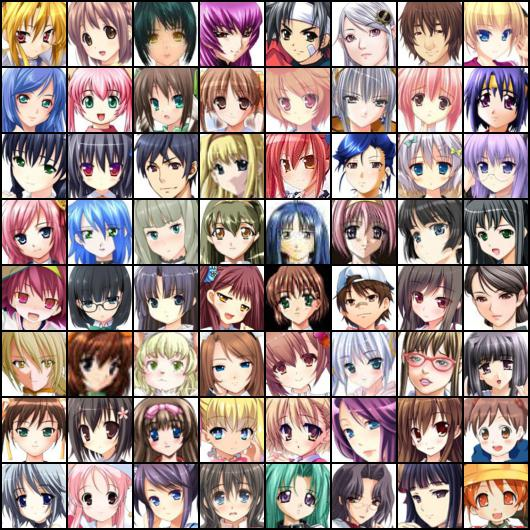

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
import os
from PIL import Image
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:

# Download latest version
path = kagglehub.dataset_download("vedsuthar/anime-faces-512x512-without-black-strips")
path2 = kagglehub.dataset_download("splcher/animefacedataset")

print("Path to dataset files:", path)
print("Path to dataset files:", path2)

Using Colab cache for faster access to the 'anime-faces-512x512-without-black-strips' dataset.
Using Colab cache for faster access to the 'animefacedataset' dataset.
Path to dataset files: /kaggle/input/anime-faces-512x512-without-black-strips
Path to dataset files: /kaggle/input/animefacedataset


In [ ]:
# Transformamos la imagen

resolution = (64,64)

transform = transforms.Compose([
    transforms.Resize(resolution),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:

# Carpeta con las imágenes
folder2 = "/kaggle/input/animefacedataset/images"
#folder = "/root/.cache/kagglehub/datasets/splcher/animefacedataset/versions/3/images"
folder = "/root/.cache/kagglehub/datasets/vedsuthar/anime-faces-512x512-without-black-strips/versions/9/anime-face-dataset-512x512-black-strip-removed"
#folder = "/kaggle/input/anime-faces-512x512-without-black-strips"

tensors = []
tensors2 = []

for filename in os.listdir(folder):
    if len(tensors) >= 10000:
        break
    if filename.endswith((".jpg", ".png", ".jpeg")):
        img = Image.open(os.path.join(folder, filename))
        tensor = transform(img)
        tensors.append(tensor)
for filename in os.listdir(folder2):
    if len(tensors2) >= 10000:
        break
    if filename.endswith((".jpg", ".png", ".jpeg")):
        img = Image.open(os.path.join(folder2, filename))
        tensor = transform(img)
        tensors2.append(tensor)



# Combinar todos los tensores en uno solo
dataset = torch.stack(tensors)
print(dataset.shape)  # [N, 3, H, W]

dataset2 = torch.stack(tensors2)
print(dataset2.shape)  # [N, 3, H, W]


torch.Size([10000, 3, 64, 64])
torch.Size([10000, 3, 64, 64])


In [ ]:
latent_dim = 100
lr = 0.00005
beta1 = 0.5
beta2 = 0.999
num_epochs = 100
batch_size = 64

In [ ]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader2 = DataLoader(dataset2, batch_size=batch_size, shuffle=True)
print(f"Número de lotes: {len(dataloader)}")

Número de lotes: 157


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.25),

        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        nn.ZeroPad2d((0, 1, 0, 1)),
        nn.BatchNorm2d(64, momentum=0.82),
        nn.LeakyReLU(0.25),
        nn.Dropout(0.25),

        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(128, momentum=0.82),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.25),

        nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(256, momentum=0.8),
        nn.LeakyReLU(0.25),
        nn.Dropout(0.25),

        nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(512, momentum=0.8),
        nn.LeakyReLU(0.25),
        nn.Dropout(0.25),

        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(512, 1),
        nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity

In [ ]:
# Arquitectura más profunda
class DeeperGenerator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_dim, 512 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (512, 4, 4)),

            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 3, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

In [ ]:
generator = DeeperGenerator(latent_dim).to(device)
discriminator = Discriminator().to(device)

adversarial_loss = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

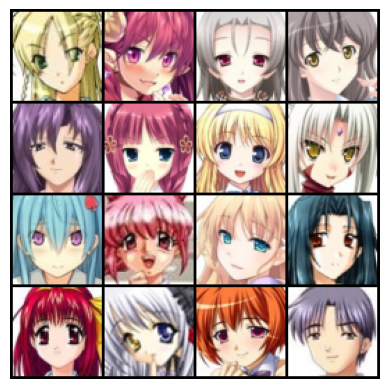

In [ ]:
img = dataset2[0:16]
grid = torchvision.utils.make_grid(img, nrow=4, normalize=True)
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis("off")
plt.show()

Epoch 1, Batch 156: D_loss=0.6575, G_loss=0.7248


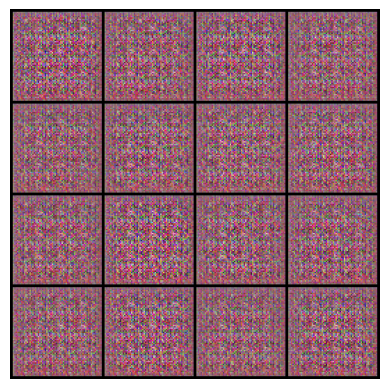

Epoch 6, Batch 156: D_loss=0.6824, G_loss=0.7179


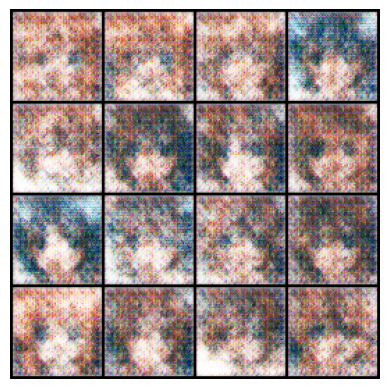

Epoch 11, Batch 156: D_loss=0.7064, G_loss=0.6721


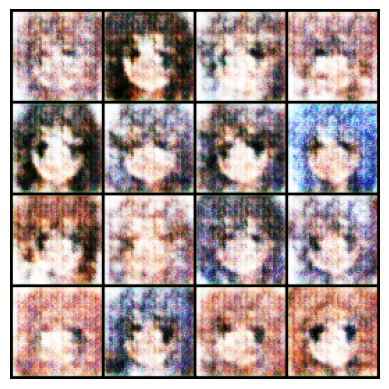

Epoch 16, Batch 156: D_loss=0.6917, G_loss=0.7130


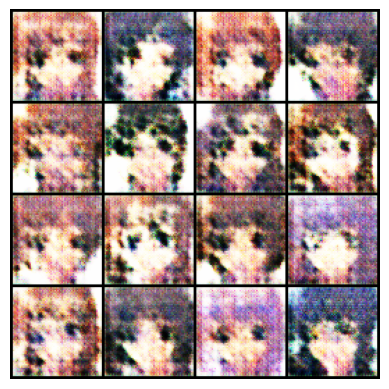

Epoch 21, Batch 156: D_loss=0.6862, G_loss=0.7298


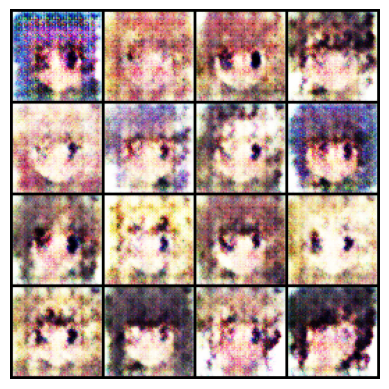

Epoch 26, Batch 156: D_loss=0.6635, G_loss=0.6820


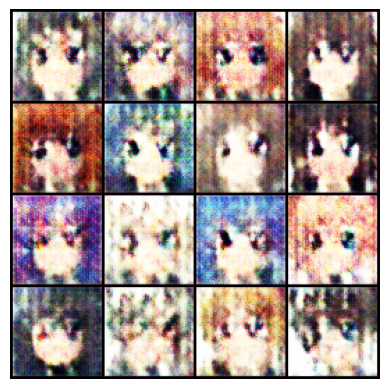

Epoch 31, Batch 156: D_loss=0.7072, G_loss=0.6927


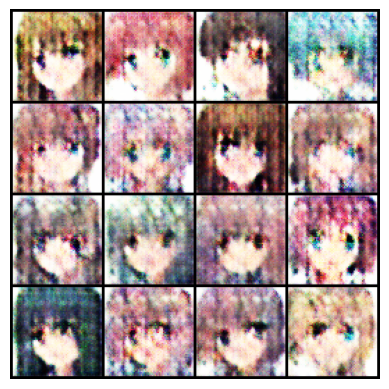

Epoch 36, Batch 156: D_loss=0.6835, G_loss=0.6991


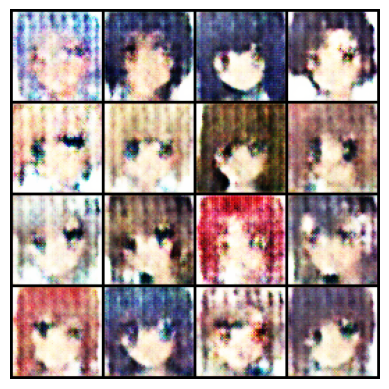

Epoch 41, Batch 156: D_loss=0.6938, G_loss=0.7246


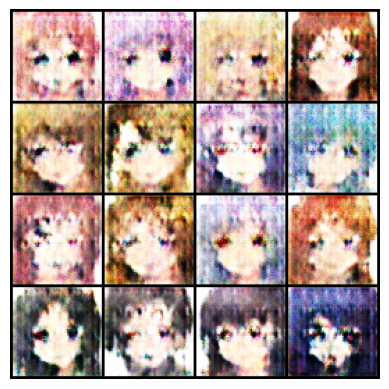

Epoch 46, Batch 156: D_loss=0.6748, G_loss=0.6847


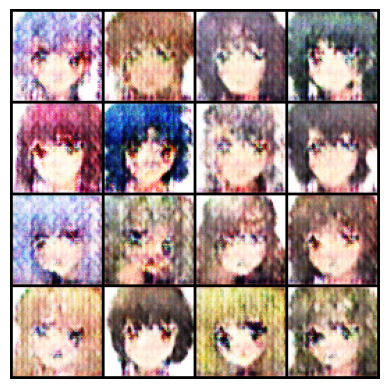

Epoch 51, Batch 156: D_loss=0.6685, G_loss=0.7156


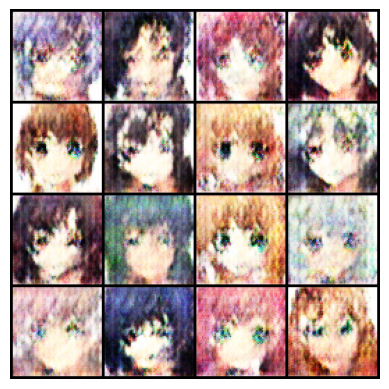

Epoch 56, Batch 156: D_loss=0.6884, G_loss=0.6914


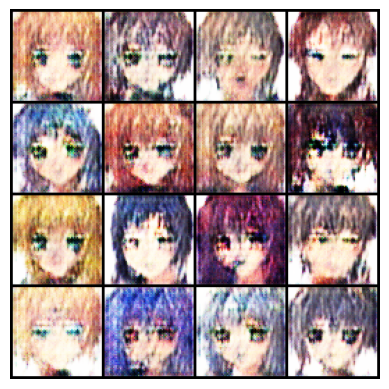

Epoch 61, Batch 156: D_loss=0.7105, G_loss=0.7126


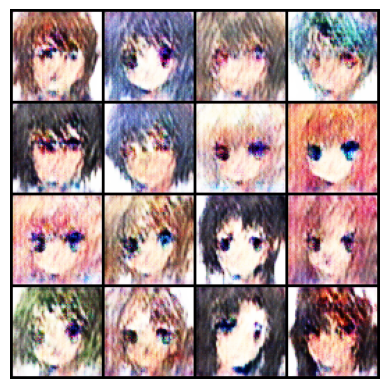

Epoch 66, Batch 156: D_loss=0.6754, G_loss=0.7139


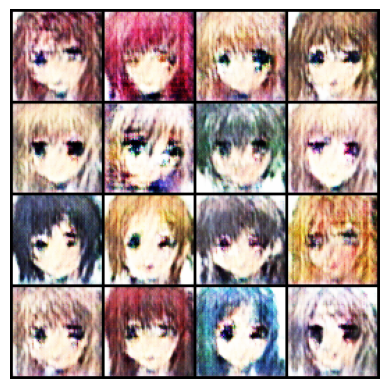

Epoch 71, Batch 156: D_loss=0.6744, G_loss=0.7368


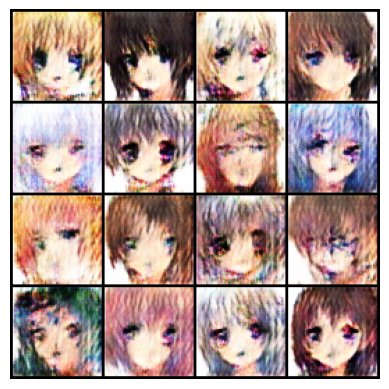

Epoch 76, Batch 156: D_loss=0.6925, G_loss=0.7311


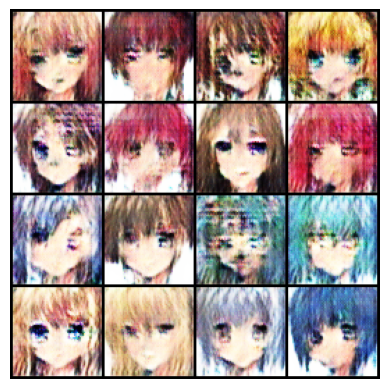

Epoch 81, Batch 156: D_loss=0.6856, G_loss=0.6841


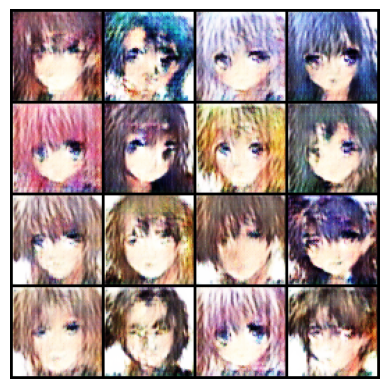

Epoch 86, Batch 156: D_loss=0.6772, G_loss=0.6986


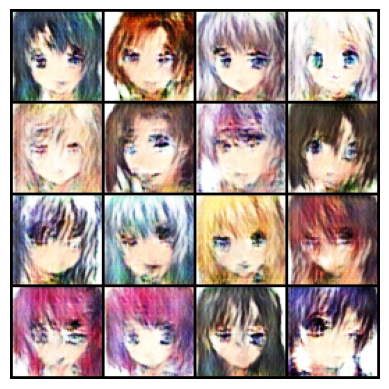

Epoch 91, Batch 156: D_loss=0.6548, G_loss=0.7161


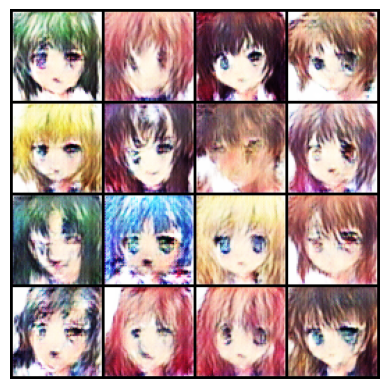

Epoch 96, Batch 156: D_loss=0.6753, G_loss=0.7061


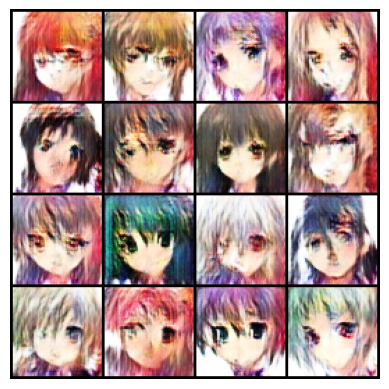

In [ ]:
# Añade estas variables al inicio
save_interval = 10  # Guardar cada 5 épocas
save = False  # Activar/desactivar el guardado de modelos
save_path = "/content/drive/MyDrive/Deep learning/Models/"

# Crea la carpeta si no existe
import os
os.makedirs(save_path, exist_ok=True)

last_epoch = 0


for epoch in range(last_epoch,num_epochs):
    for i, batch in enumerate(dataloader2):

        real_images = batch.to(device)
        #print("imagenes reales",real_images.shape)


        valid = torch.ones(real_images.size(0), 1, device=device)
        fake = torch.zeros(real_images.size(0), 1, device=device)

        real_images = real_images.to(device)

        optimizer_D.zero_grad()

        z = torch.randn(real_images.size(0), latent_dim, device=device)

        fake_images = generator(z)

        real_loss = adversarial_loss(discriminator(real_images), valid)

        fake_loss = adversarial_loss(discriminator(fake_images.detach()), fake)

        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()

        optimizer_D.step()

        optimizer_G.zero_grad()

        gen_images = generator(z)

        g_loss = adversarial_loss(discriminator(gen_images), valid)
        g_loss.backward()
        optimizer_G.step()


    if (epoch) % save_interval == 0:

        print(f"Epoch {epoch+1}, Batch {i}: D_loss={d_loss.item():.4f}, G_loss={g_loss.item():.4f}")
        if(save):
            # Guardar generator
            torch.save(generator.state_dict(),
                    f"{save_path}generator_epoch_{epoch+1}.pth")
            # Guardar discriminator
            torch.save(discriminator.state_dict(),
                    f"{save_path}discriminator_epoch_{epoch+1}.pth")
            # Guardar optimizers (opcional)
            torch.save(optimizer_G.state_dict(),
                    f"{save_path}optimizer_G_epoch_{epoch+1}.pth")
            torch.save(optimizer_D.state_dict(),
                    f"{save_path}optimizer_D_epoch_{epoch+1}.pth")

            print(f"Modelos guardados en época {epoch+1}")

        # Generar imágenes falsas y mostrarlas
        with torch.no_grad():
            z = torch.randn(16, latent_dim, device=device)
            generated = generator(z).detach().cpu()
            grid = torchvision.utils.make_grid(generated, nrow=4, normalize=True)
            plt.imshow(np.transpose(grid, (1, 2, 0)))
            plt.axis("off")
            plt.show()